This notebook will be for data cleaning

Problem statement:
We are trying to optimize the WTWY signature-gathering team's placement for raising awareness of upcoming gala in June 2019. 

The end goals:
1. rank stations by foot traffic
2. plot 5 top stations by total traffic - hourly, daily, weekly
3. analyze demographics for top 5 stations - gender, income, industry
4. create scorecard with weighed combination of factors for each station

In [62]:
import pandas as pd

In [84]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [190504,190511,190518,190525]
mta_df = get_data(week_nums)

In [85]:
# fixing EXITS label
mta_df.rename(columns={"EXITS                                                               ":'EXITS'},inplace=True)

In [86]:
mta_df.head()

C/A  UNIT       SCP STATION LINENAME DIVISION        DATE      TIME  \
0  A002  R051  02-00-00   59 ST  NQR456W      BMT  04/27/2019  00:00:00   
1  A002  R051  02-00-00   59 ST  NQR456W      BMT  04/27/2019  04:00:00   
2  A002  R051  02-00-00   59 ST  NQR456W      BMT  04/27/2019  08:00:00   
3  A002  R051  02-00-00   59 ST  NQR456W      BMT  04/27/2019  12:00:00   
4  A002  R051  02-00-00   59 ST  NQR456W      BMT  04/27/2019  16:00:00   

      DESC  ENTRIES    EXITS  
0  REGULAR  7035249  2384833  
1  REGULAR  7035269  2384840  
2  REGULAR  7035292  2384875  
3  REGULAR  7035392  2384951  
4  REGULAR  7035651  2385020

In [87]:
# converting to datetime
mta_df["DATE_TIME"] = pd.to_datetime(mta_df.DATE + " " + mta_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [88]:
# dropping duplicates
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [98]:
mta_daily = (mta_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        ['ENTRIES','EXITS'].first())

<ipython-input-98-277383eb6d8a>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mta_daily = (mta_df


In [99]:
mta_daily.head()

C/A  UNIT       SCP STATION        DATE  ENTRIES    EXITS
0  A002  R051  02-00-00   59 ST  04/27/2019  7035249  2384833
1  A002  R051  02-00-00   59 ST  04/28/2019  7036100  2385087
2  A002  R051  02-00-00   59 ST  04/29/2019  7036746  2385256
3  A002  R051  02-00-00   59 ST  04/30/2019  7038242  2385765
4  A002  R051  02-00-00   59 ST  05/01/2019  7039729  2386229

In [121]:
# creating previous entries, previous exits, previous date
mta_daily[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (mta_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES",'EXITS']
                                                       .apply(lambda grp: grp.shift(1)))

<ipython-input-121-753df28e3dd2>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mta_daily[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (mta_daily


In [122]:
mta_daily.head()

C/A  UNIT       SCP STATION        DATE  ENTRIES    EXITS   PREV_DATE  \
0  A002  R051  02-00-00   59 ST  04/27/2019  7035249  2384833         NaN   
1  A002  R051  02-00-00   59 ST  04/28/2019  7036100  2385087  04/27/2019   
2  A002  R051  02-00-00   59 ST  04/29/2019  7036746  2385256  04/28/2019   
3  A002  R051  02-00-00   59 ST  04/30/2019  7038242  2385765  04/29/2019   
4  A002  R051  02-00-00   59 ST  05/01/2019  7039729  2386229  04/30/2019   

   PREV_ENTRIES  PREV_EXITS  
0           NaN         NaN  
1     7035249.0   2384833.0  
2     7036100.0   2385087.0  
3     7036746.0   2385256.0  
4     7038242.0   2385765.0

In [123]:
# dropping NAs in the new columns
mta_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [125]:
# calculating real daily entries and exits
def get_daily_entries(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

def get_daily_exits(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["EXITS"], row["PREV_EXITS"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

In [143]:
# dropping highest 1% of daily entries and activity
quant_filt = 0.99
q = data["DAILY_ENTRIES"].quantile(quant_filt)
data = data[data["DAILY_ENTRIES"] < q]
r = data["DAILY_ENTRIES"].quantile(quant_filt)
data = data[data["DAILY_ENTRIES"] < r]
s = data["DAILY_ACTIVITY"].quantile(quant_filt)
data = data[data["DAILY_ACTIVITY"] < s]
data = data.dropna() # apparently no issues with NaN cells; running as best practice
data.head()

C/A  UNIT       SCP STATION        DATE  ENTRIES    EXITS   PREV_DATE  \
1  A002  R051  02-00-00   59 ST  04/28/2019  7036100  2385087  04/27/2019   
2  A002  R051  02-00-00   59 ST  04/29/2019  7036746  2385256  04/28/2019   
3  A002  R051  02-00-00   59 ST  04/30/2019  7038242  2385765  04/29/2019   
4  A002  R051  02-00-00   59 ST  05/01/2019  7039729  2386229  04/30/2019   
5  A002  R051  02-00-00   59 ST  05/02/2019  7041303  2386712  05/01/2019   

   PREV_ENTRIES  PREV_EXITS  DAILY_ENTRIES  DAILY_EXITS  DAILY_ACTIVITY  
1     7035249.0   2384833.0          851.0        254.0          1105.0  
2     7036100.0   2385087.0          646.0        169.0           815.0  
3     7036746.0   2385256.0         1496.0        509.0          2005.0  
4     7038242.0   2385765.0         1487.0        464.0          1951.0  
5     7039729.0   2386229.0         1574.0        483.0          2057.0

In [142]:
data = mta_daily

In [144]:
data.DAILY_ACTIVITY.describe()

count    126361.000000
mean       1764.595389
std        1459.176588
min           0.000000
25%         584.000000
50%        1488.000000
75%        2672.000000
max        6610.000000
Name: DAILY_ACTIVITY, dtype: float64

In [145]:
mta_daily.DAILY_ACTIVITY.describe()

count    130234.000000
mean       2051.670793
std        7231.710039
min           0.000000
25%         611.000000
50%        1548.000000
75%        2819.000000
max      849456.000000
Name: DAILY_ACTIVITY, dtype: float64

In [132]:
# applying functions to mta dataset
mta_daily["DAILY_ENTRIES"] = mta_daily.apply(get_daily_entries, axis=1, max_counter=500000)
mta_daily["DAILY_EXITS"] = mta_daily.apply(get_daily_exits, axis=1, max_counter=500000)

882 15418815.0
1435 4767402.0
335092671 3422305.0
412 3073070.0
161 4605408.0
681 6527713.0
65536 839317244.0
184608117 746094.0
238 2898346.0
50 1544092.0
607 3912014.0
196614 2998692.0
514 3755842.0
8 2020892.0
132263 737704.0
3003 6999467.0
408 8876564.0
1178879075 4471988.0
1221 649233.0
706 899109.0
4666 2201975.0
2665 666653.0
196633 68461839.0
200 36966261.0
1277 863113.0
1017 2357557.0
12 4887309.0
7 9441168.0
1058702 102390686.0
10 7602347.0
1463 1068632.0
183 724272.0
251 567679.0
29 6332751.0
30933207 6069289.0
115 12739117.0
1122 6546797.0
16779493 81157.0
637574909 2502854.0
68859156 436510383.0
607126914 594465.0
140397413 1577638340.0
458752 100663296.0
259 7480462.0
683737068 458752.0
905996437 3558247.0
0 5176463.0
7 13653544.0
182 10462950.0
2063649382 8123310.0
1129054878 2501599.0
1394 7550893.0
1778 2816656.0
335092104 2643003.0
68 906192.0
33 1931999.0
1516 8479992.0
2 167841841.0
16785950 71764.0
485 2358031.0
302 2844657.0
257 3657212.0
12 7146400.0
152 2893126.

In [133]:
mta_daily.DAILY_EXITS.describe()

count    130234.000000
mean        905.806387
std        4254.127576
min           0.000000
25%         158.000000
50%         524.000000
75%        1164.000000
max      479455.000000
Name: DAILY_EXITS, dtype: float64

In [140]:
mta_daily.DAILY_ACTIVITY.describe()

count    130234.000000
mean       2051.670793
std        7231.710039
min           0.000000
25%         611.000000
50%        1548.000000
75%        2819.000000
max      849456.000000
Name: DAILY_ACTIVITY, dtype: float64

In [136]:
mta_daily.drop('DAILY EXITS',inplace=True, axis = 1)

In [138]:
# new column of daily activity
mta_daily['DAILY_ACTIVITY'] = mta_daily['DAILY_ENTRIES'] + mta_daily['DAILY_EXITS']

In [146]:
# here I begin to use the data df instead of mta, because we applied statistical analysis that worked

In [147]:
data.head()

C/A  UNIT       SCP STATION        DATE  ENTRIES    EXITS   PREV_DATE  \
1  A002  R051  02-00-00   59 ST  04/28/2019  7036100  2385087  04/27/2019   
2  A002  R051  02-00-00   59 ST  04/29/2019  7036746  2385256  04/28/2019   
3  A002  R051  02-00-00   59 ST  04/30/2019  7038242  2385765  04/29/2019   
4  A002  R051  02-00-00   59 ST  05/01/2019  7039729  2386229  04/30/2019   
5  A002  R051  02-00-00   59 ST  05/02/2019  7041303  2386712  05/01/2019   

   PREV_ENTRIES  PREV_EXITS  DAILY_ENTRIES  DAILY_EXITS  DAILY_ACTIVITY  
1     7035249.0   2384833.0          851.0        254.0          1105.0  
2     7036100.0   2385087.0          646.0        169.0           815.0  
3     7036746.0   2385256.0         1496.0        509.0          2005.0  
4     7038242.0   2385765.0         1487.0        464.0          1951.0  
5     7039729.0   2386229.0         1574.0        483.0          2057.0

In [179]:
# top 5 stations
top10_stations = (mta_daily.groupby(['STATION'])['DAILY_ACTIVITY'].sum()
                   .reset_index()
                   .sort_values(by='DAILY_ACTIVITY',ascending=False) 
                   .head(10)
                 )

top10_stations

STATION  DAILY_ACTIVITY
61    34 ST-PENN STA       7734136.0
232  GRD CNTRL-42 ST       6699010.0
59   34 ST-HERALD SQ       5717204.0
46             23 ST       5334288.0
14    14 ST-UNION SQ       5332985.0
110            86 ST       4875680.0
352   TIMES SQ-42 ST       4791829.0
68   42 ST-PORT AUTH       4578932.0
225        FULTON ST       4168519.0
314     PATH NEW WTC       4078374.0

In [180]:
# plotting top 10 stations by daily activity
import matplotlib.pyplot as plt
%matplotlib inline

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

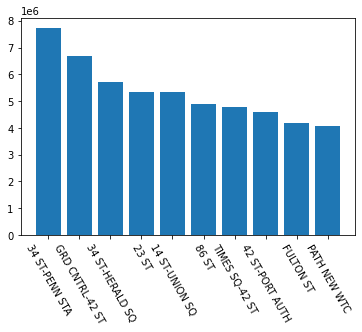

In [186]:
plt.bar('STATION','DAILY_ACTIVITY',data=top10_stations)
plt.xticks(rotation=300)

In [170]:
type(top10_stations)

pandas.core.series.Series